* Cory Clayton (acc2ds@virginia.edu)
- DS5001
- 6 May 2021


# Clustering all the movies by TF_max

## Set up

In [1]:
data_in = './data_in/'
data_out = './data_out/'
data_prefix = 'movie'

In [2]:
OHCO = ['genre','author','Book','chapter','para_num','sent_num','token_num']


In [3]:
OHCO = ['movie_id', 'Action_number', 'Dialogue_num','sent_num']
DIALOGUE = OHCO[:3]
ACTION = OHCO[:2]
MOVIE = OHCO[:1]

tfidf_sum = 'tfidf_max_sum'

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.spatial.distance import pdist, squareform

import plotly_express as px
import seaborn as sns
sns.set(style='ticks')

In [5]:
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB.csv').set_index('movie_id')
VOCAB = pd.read_csv(f'{data_in}/{data_prefix}-VOCAB.csv').set_index('term_str')
TOKEN = pd.read_csv(f'{data_in}/{data_prefix}-TOKENS.csv').set_index(OHCO[2:])

In [6]:
LIB

,name,studio,director,genre,year
movie_id,,,,,
m1,Rogue One: A Star Wars Story,Lucasfilm Ltd.,Gareth Edwards,Action Adventure Science Fiction,2016
m2,Star Wars: Episode III - Revenge of the Sith,Lucasfilm Ltd.,George Lucas,Action Science Fiction Adventure,2005
m3,Star Wars: The Rise of Skywalker,Lucasfilm Ltd.,J.J. Abrams,Science Fiction Adventure Action,2019
m4,Captain America: The First Avenger,Marvel Studios,Joe Johnston,Science Fiction Action Adventure,2011
m5,Captain America: The Winter Soldier,Marvel Studios,Anthony Russo Joe Russo,Action Adventure Science Fiction,2014
m6,Captain America: Civil War,Marvel Studios,Anthony Russo Joe Russo,Action Science Fiction Adventure,2016
m7,The Avengers,Marvel Studios,Joss Whedon,Science Fiction Adventure Action,2012
m8,Avengers: Age of Ultron,Marvel Studios,Joss Whedon,Science Fiction Action Adventure,2015
m9,Avengers: Infinity War,Marvel Studios,Anthony Russo Joe Russo,Adventure Action Science Fiction,2018


### get a BOW

I had to group on movie, when I tried to group on action it was a a giant nonsense cluster. 

In [7]:
alpha=.4

BOW = TOKEN.groupby(MOVIE+['term_str'])['term_str'].count()\
    .to_frame('n')

D = BOW.groupby(MOVIE).n

BOW['tf'] = D.apply(lambda x: alpha + (1-alpha) * (x / x.max()))
BOW['tfidf'] = BOW.tf * VOCAB.idf

reduce vocab to 4000 words

In [8]:
VOCAB[VOCAB['tfidf_max_sum'] >= VOCAB['tfidf_max_sum'].quantile(.67)]

,n,num,stop,pos_max,p,s,i,h,wlen,df,idf,tfidf_n_sum,tfidf_jp_sum,tfidf_cp_sum,tfidf_l2_sum,tfidf_logn_sum,tfidf_sub_sum,tfidf_max_sum,tfidf_bool_sum
term_str,,,,,,,,,,,,,,,,,,,
0,3,1,0,CD,0.000015,67824.666667,16.049522,0.000237,1,2,11.336228,0.000014,0.000049,0.000049,0.000044,0.000014,0.000016,0.000021,0.000033
1,16,1,0,CD,0.000079,12717.125000,13.634485,0.001072,1,14,8.528873,0.000080,0.000123,0.000123,0.000118,0.000095,0.000088,0.000120,0.000135
10,6,1,0,CD,0.000029,33912.333333,15.049522,0.000444,2,6,9.751265,0.000030,0.000015,0.000015,0.000024,0.000038,0.000034,0.000037,0.000024
100,13,1,0,CD,0.000064,15651.846154,13.934045,0.000890,3,12,8.751265,0.000065,0.000030,0.000030,0.000047,0.000080,0.000074,0.000078,0.000041
11,5,1,0,CD,0.000025,40694.800000,15.312557,0.000376,2,4,10.336228,0.000025,0.000033,0.000033,0.000036,0.000029,0.000029,0.000031,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
родину,4,0,0,NN,0.000020,50868.500000,15.634485,0.000307,6,3,10.751265,0.000020,0.000039,0.000039,0.000042,0.000021,0.000022,0.000037,0.000039
семнадцать,2,0,0,NN,0.000010,101737.000000,16.634485,0.000164,10,2,11.336228,0.000007,0.000017,0.000017,0.000023,0.000008,0.000008,0.000023,0.000019
солдат,4,0,0,NN,0.000020,50868.500000,15.634485,0.000307,6,4,10.336228,0.000019,0.000107,0.000107,0.000080,0.000024,0.000021,0.000058,0.000111


### produce TFIDF table

In [9]:
TFIDF = BOW['tfidf'].unstack(fill_value=0)

VSHORT = VOCAB[VOCAB['tfidf_max_sum'] >= VOCAB['tfidf_max_sum'].quantile(.67)]
TFIDF = TFIDF[VSHORT.index]

In [10]:
#TFIDF=TFIDF.apply(lambda x: x / norm(x), 1)
#TFIDF = TFIDF - TFIDF.mean()

In [11]:
#there were some nan causing trouble
TFIDF=TFIDF.dropna()


## get tfidf by movie

In [12]:
TFIDF_movie = TFIDF.groupby(MOVIE).sum()

In [13]:
TFIDF_movie

term_str,0,1,10,100,11,117,12,13,14th,15,...,один,отвечать,печь,рассвет,ржавый,родину,семнадцать,солдат,я,いらっしゃいませ
movie_id,,,,,,,,,,,,,,,,,,,,,
m1,0.000000,0.000000,3.930665,0.000000,0.000000,0.000000,3.960823,0.000000,0.000000,4.021206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m10,0.000000,3.447842,3.914338,3.512919,0.000000,0.000000,0.000000,0.000000,4.315756,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m11,4.557705,0.000000,0.000000,3.518427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.923632,0.000000,0.000000,4.029469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m14,0.000000,3.445894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m15,0.000000,3.449315,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.584688
m16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
m17,4.571659,0.000000,0.000000,3.514852,0.000000,0.000000,0.000000,0.000000,0.000000,4.022137,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
LIB

,name,studio,director,genre,year
movie_id,,,,,
m1,Rogue One: A Star Wars Story,Lucasfilm Ltd.,Gareth Edwards,Action Adventure Science Fiction,2016
m2,Star Wars: Episode III - Revenge of the Sith,Lucasfilm Ltd.,George Lucas,Action Science Fiction Adventure,2005
m3,Star Wars: The Rise of Skywalker,Lucasfilm Ltd.,J.J. Abrams,Science Fiction Adventure Action,2019
m4,Captain America: The First Avenger,Marvel Studios,Joe Johnston,Science Fiction Action Adventure,2011
m5,Captain America: The Winter Soldier,Marvel Studios,Anthony Russo Joe Russo,Action Adventure Science Fiction,2014
m6,Captain America: Civil War,Marvel Studios,Anthony Russo Joe Russo,Action Science Fiction Adventure,2016
m7,The Avengers,Marvel Studios,Joss Whedon,Science Fiction Adventure Action,2012
m8,Avengers: Age of Ultron,Marvel Studios,Joss Whedon,Science Fiction Action Adventure,2015
m9,Avengers: Infinity War,Marvel Studios,Anthony Russo Joe Russo,Adventure Action Science Fiction,2018


In [16]:
LIB['tfidf_sum'] = TFIDF_movie.sum(1).sort_index()
LIB['tfidf_mean'] = TFIDF_movie.mean(1).sort_index()

In [17]:
LIB

,name,studio,director,genre,year,tfidf_sum,tfidf_mean
movie_id,,,,,,,
m1,Rogue One: A Star Wars Story,Lucasfilm Ltd.,Gareth Edwards,Action Adventure Science Fiction,2016,3598.475254,0.874265
m2,Star Wars: Episode III - Revenge of the Sith,Lucasfilm Ltd.,George Lucas,Action Science Fiction Adventure,2005,4147.389525,1.007626
m3,Star Wars: The Rise of Skywalker,Lucasfilm Ltd.,J.J. Abrams,Science Fiction Adventure Action,2019,3247.629463,0.789026
m4,Captain America: The First Avenger,Marvel Studios,Joe Johnston,Science Fiction Action Adventure,2011,4044.518063,0.982633
m5,Captain America: The Winter Soldier,Marvel Studios,Anthony Russo Joe Russo,Action Adventure Science Fiction,2014,4651.437642,1.130087
m6,Captain America: Civil War,Marvel Studios,Anthony Russo Joe Russo,Action Science Fiction Adventure,2016,4716.712538,1.145946
m7,The Avengers,Marvel Studios,Joss Whedon,Science Fiction Adventure Action,2012,4431.778640,1.076720
m8,Avengers: Age of Ultron,Marvel Studios,Joss Whedon,Science Fiction Action Adventure,2015,4552.739811,1.106108
m9,Avengers: Infinity War,Marvel Studios,Anthony Russo Joe Russo,Adventure Action Science Fiction,2018,4056.533821,0.985552


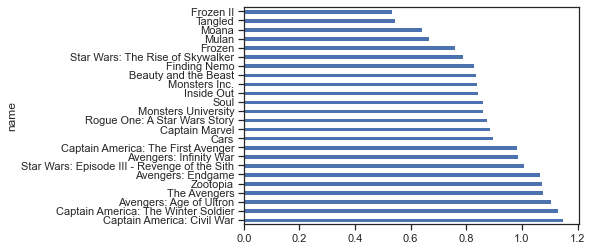

In [18]:
LIB.sort_values('tfidf_sum', ascending=False).reset_index().set_index('name').tfidf_mean.plot.barh()

## Get Pairs table

In [19]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [20]:
PAIRS

Empty DataFrame
Columns: []
Index: [(m1, m2), (m1, m3), (m1, m4), (m1, m5), (m1, m6), (m1, m7), (m1, m8), (m1, m9), (m1, m10), (m1, m11), (m1, m12), (m1, m13), (m1, m14), (m1, m15), (m1, m16), (m1, m17), (m1, m18), (m1, m19), (m1, m20), (m1, m21), (m1, m22), (m1, m23), (m1, m24), (m2, m3), (m2, m4), (m2, m5), (m2, m6), (m2, m7), (m2, m8), (m2, m9), (m2, m20), (m2, m21), (m2, m22), (m2, m23), (m2, m24), (m3, m4), (m3, m5), (m3, m6), (m3, m7), (m3, m8), (m3, m9), (m4, m5), (m4, m6), (m4, m7), (m4, m8), (m4, m9), (m5, m6), (m5, m7), (m5, m8), (m5, m9), (m6, m7), (m6, m8), (m6, m9), (m7, m8), (m7, m9), (m8, m9), (m10, m2), (m10, m3), (m10, m4), (m10, m5), (m10, m6), (m10, m7), (m10, m8), (m10, m9), (m10, m11), (m10, m12), (m10, m13), (m10, m14), (m10, m15), (m10, m16), (m10, m17), (m10, m18), (m10, m19), (m10, m20), (m10, m21), (m10, m22), (m10, m23), (m10, m24), (m11, m2), (m11, m3), (m11, m4), (m11, m5), (m11, m6), (m11, m7), (m11, m8), (m11, m9), (m11, m12), (m11, m13), (m11, m14), (m11, m15), (m11, m16), (m11, m17), (m11, m18), (m11, m19), (m11, m20), (m11, m21), (m11, m22), (m11, m23), (m11, m24), (m12, m2), ...]

[276 rows x 0 columns]

In [21]:
TFIDF_movie_short = TFIDF_movie[VSHORT.index]
df=TFIDF_movie_short.dropna()

###compute pairs values

In [23]:
L0 = df.astype('bool').astype('int') # Boolean
L1 = df.apply(lambda x: x / x.sum(), 1)
L2 = df.apply(lambda x: x / norm(x), 1)

In [24]:
PAIRS['cityblock'] = pdist(df, 'cityblock')
PAIRS['euclidean'] = pdist(df, 'euclidean')
PAIRS['cosine'] = pdist(df, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')                               
PAIRS['euclidean2'] = pdist(L2, 'euclidean')

In [25]:
PAIRS.sort_values('cosine', ascending=False).style.background_gradient(cmap='GnBu', high=.5)

In [26]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [27]:
LIB['Label'] = LIB.apply(lambda x: "{}: {} ({})".format(x.studio, x['name'], x.year), axis=1).values

## Dendrogram graphs

In [28]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB['Label'].values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=list(labels), 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

### Cosine

<Figure size 432x288 with 0 Axes>

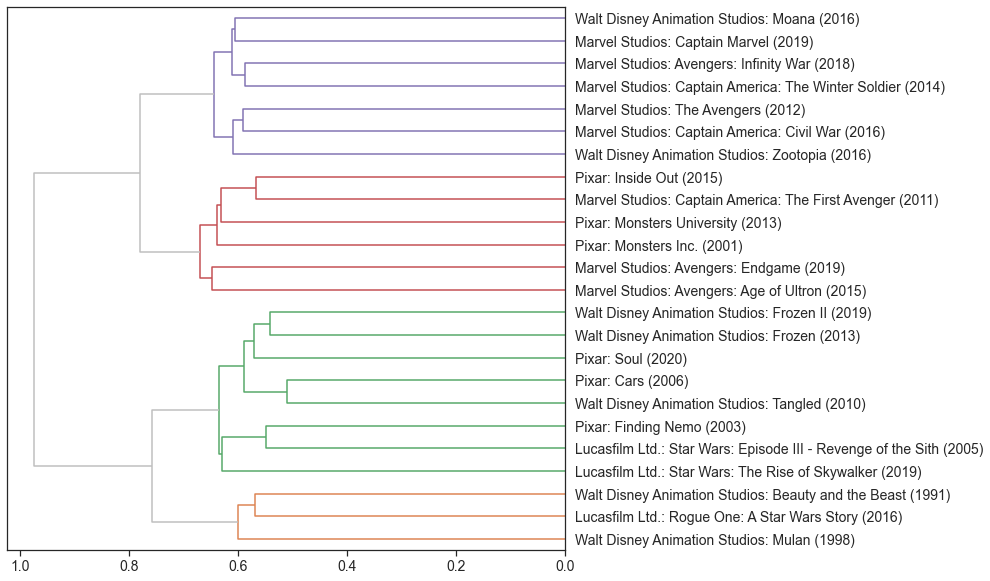

In [35]:
hca(PAIRS.cosine, color_thresh=0.7)

<Figure size 432x288 with 0 Axes>

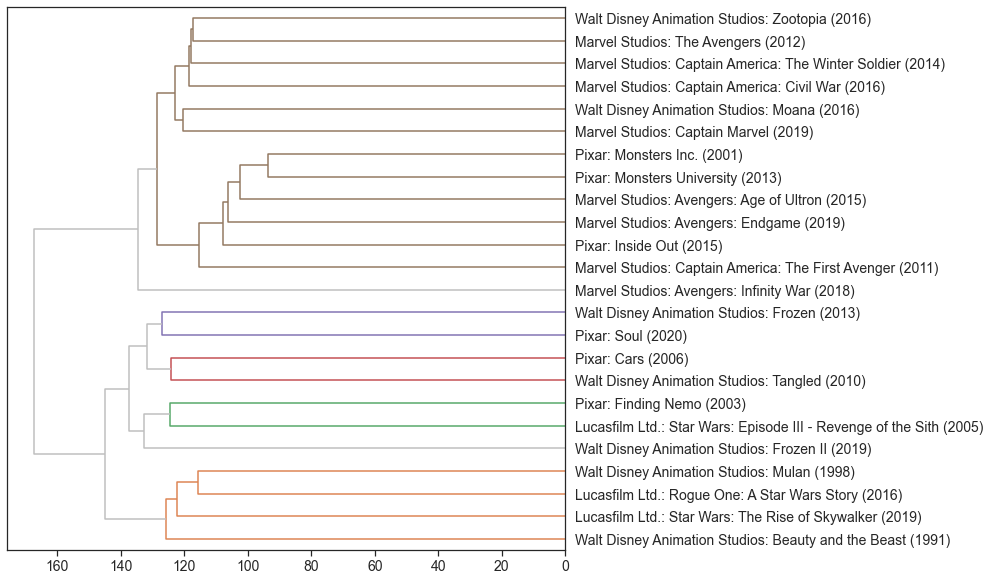

In [36]:
hca(PAIRS.euclidean, color_thresh=130)

### Jensen Shannon

<Figure size 432x288 with 0 Axes>

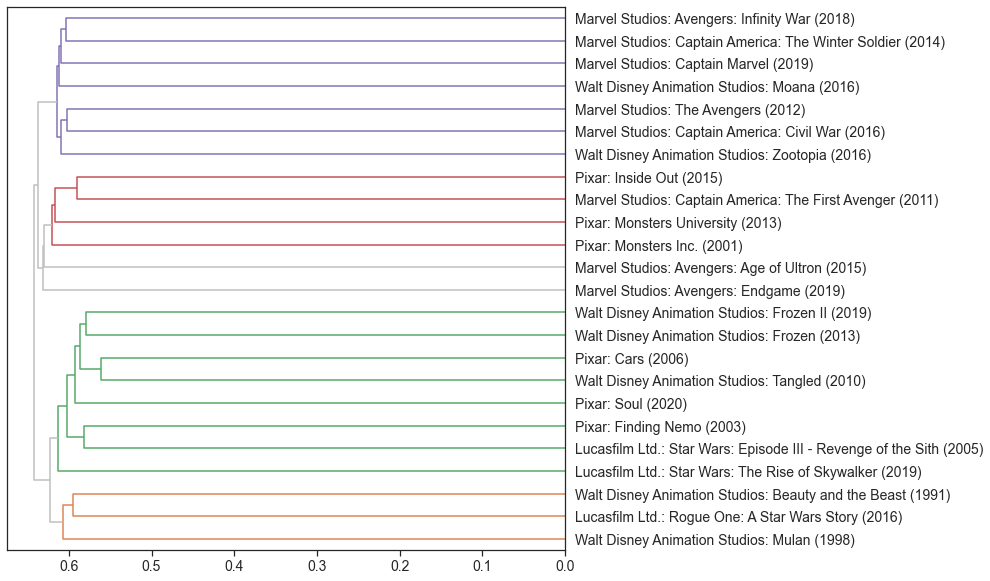

In [34]:
hca(PAIRS.js, linkage_method='weighted', color_thresh=.62)